In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import seaborn as sns

In [3]:
titanic_df = pd.read_csv('/kaggle/input/titanic/train.csv')
testing_df = pd.read_csv('/kaggle/input/titanic/test.csv')
testing_columns = testing_df.columns.to_list()
testing_copy = testing_df.copy()
print(titanic_df.shape)
titanic_df.head(3)

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [4]:
training_df, training_target = titanic_df.drop(columns=['PassengerId', 'Survived', 'Ticket']), titanic_df['Survived']
training_df.shape, training_target.shape

((891, 9), (891,))

In [5]:
testing_df = testing_df.drop(columns=['PassengerId', 'Ticket'])
testing_df.shape

(418, 9)

In [6]:
training_df.isna().sum()

Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [7]:
def perform_eda(df):
    
    df['Title'] = df['Name'].apply(lambda x: x.split(",")[-1].split(".")[0])
    df['Title'] = df['Title'].apply(lambda x: x if x.startswith("M") else "Other")
    
    df['Family'] = df['Parch'] + df['SibSp']
        
    df = df.drop(columns = ['Name', 'Parch', 'SibSp', 'Cabin'])
        
    return df

In [8]:
training_df = perform_eda(training_df)
testing_df = perform_eda(testing_df)

In [9]:
training_df.head(3)

,Pclass,Sex,Age,Fare,Embarked,Title,Family
0,3,male,22.0,7.2500,S,Other,1
1,1,female,38.0,71.2833,C,Other,1
2,3,female,26.0,7.9250,S,Other,0


In [10]:
numeric_cols = ['Fare', 'Age']
categoric_cols = ['Sex', 'Title', 'Family', 'Embarked']
other_cols = ['Pclass']

In [11]:
training_df[numeric_cols].isna().sum()

Fare      0
Age     177
dtype: int64

<AxesSubplot:xlabel='Age', ylabel='Density'>

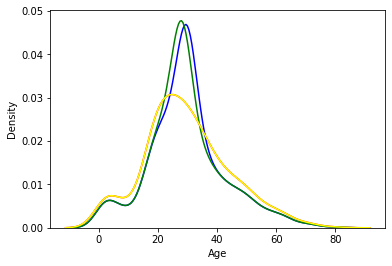

In [12]:
sns.kdeplot(training_df['Age'], color='red')
sns.kdeplot(training_df['Age'].fillna(training_df['Age'].mean()), color='blue')
sns.kdeplot(training_df['Age'].fillna(training_df['Age'].median()), color='green')
sns.kdeplot(training_df['Age'].dropna(), color='yellow')

In [13]:
def preprocess_numeric_data(df, columns):
    
    from sklearn.impute import SimpleImputer
    
    imputer = SimpleImputer(strategy='median')
    
    imputer = imputer.fit(df[columns])
    df[columns] = imputer.transform(df[columns])
    
    
    from sklearn.preprocessing import StandardScaler
    
    scaler = StandardScaler()
    
    scaler = scaler.fit(df[columns])
    df[columns] = scaler.transform(df[columns])
    
    return df, imputer, scaler

In [14]:
training_df[categoric_cols].isna().sum()

Sex         0
Title       0
Family      0
Embarked    2
dtype: int64

In [15]:
def preprocess_categorical_data(df, columns):
    
    from sklearn.impute import SimpleImputer
    
    imputer = SimpleImputer(strategy='most_frequent')
    
    imputer = imputer.fit(df[columns])
    df[columns] = imputer.transform(df[columns])
    
    from sklearn.preprocessing import OneHotEncoder
    
    ohe = OneHotEncoder(sparse=False, dtype=np.int64)
    
    ohe = ohe.fit(df[columns])
    ohe_features = ohe.get_feature_names()
    df[ohe_features] = ohe.transform(df[columns])
    
    return df, ohe_features.tolist(), imputer, ohe

In [16]:
training_df, num_imputer, num_scaler = preprocess_numeric_data(training_df, numeric_cols)
training_df, ohe_features, cat_imputer, cat_encoder = preprocess_categorical_data(training_df, categoric_cols)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [17]:
training_df = training_df[numeric_cols + ohe_features + other_cols]
training_df.head(3)

,Fare,Age,x0_female,x0_male,x1_Other,x2_0,x2_1,x2_2,x2_3,x2_4,x2_5,x2_6,x2_7,x2_10,x3_C,x3_Q,x3_S,Pclass
0,-0.502445,-0.565736,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,3
1,0.786845,0.663861,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1
2,-0.488854,-0.258337,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,3


In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(training_df, training_target, test_size=0.2, random_state=42)

In [19]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 18), (179, 18), (712,), (179,))

In [20]:
from sklearn.ensemble import RandomForestClassifier

RFC = RandomForestClassifier(n_estimators=380, criterion='gini', max_depth=None, max_features='auto')

In [21]:
RFC.fit(X_train, y_train)
y_pred = RFC.predict(X_test)

In [22]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.8212290502793296

In [23]:
def preprocess_test_num_data(df, columns, num_imputer, num_scaler):
    
    df[columns] = num_imputer.transform(df[columns])
    df[columns] = num_scaler.transform(df[columns])
    
    return df

In [24]:
def preprocess_test_cat_data(df, columns, ohe_features, cat_imputer, cat_encoder):
    
    df[columns] = cat_imputer.transform(df[columns])
    df[ohe_features] = cat_encoder.transform(df[columns])
    
    return df

In [25]:
testing_df = preprocess_test_num_data(testing_df, numeric_cols, num_imputer, num_scaler)
testing_df = preprocess_test_cat_data(testing_df, categoric_cols, ohe_features, cat_imputer, cat_encoder)

In [26]:
testing_df = testing_df[numeric_cols + ohe_features + other_cols]

In [27]:
y_pred = RFC.predict(testing_df)

In [28]:
testing_df['Survived'] = y_pred
testing_df

,Fare,Age,x0_female,x0_male,x1_Other,x2_0,x2_1,x2_2,x2_3,x2_4,x2_5,x2_6,x2_7,x2_10,x3_C,x3_Q,x3_S,Pclass,Survived
0,-0.490783,0.394887,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,3,0
1,-0.507479,1.355510,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,3,0
2,-0.453367,2.508257,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,2,0
3,-0.474005,-0.181487,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,3,1
4,-0.401017,-0.565736,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,-0.486337,-0.104637,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,3,0
414,1.544246,0.740711,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,1,1
415,-0.502445,0.702286,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,3,0
416,-0.486337,-0.104637,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,3,0


In [29]:
testing_df.head(5)

,Fare,Age,x0_female,x0_male,x1_Other,x2_0,x2_1,x2_2,x2_3,x2_4,x2_5,x2_6,x2_7,x2_10,x3_C,x3_Q,x3_S,Pclass,Survived
0,-0.490783,0.394887,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,3,0
1,-0.507479,1.355510,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,3,0
2,-0.453367,2.508257,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,2,0
3,-0.474005,-0.181487,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,3,1
4,-0.401017,-0.565736,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,3,1


In [30]:
testing_copy['Survived'] = testing_df['Survived']
# testing_copy.to_csv('submission.csv', index=False)

In [31]:
testing_copy[['PassengerId', 'Survived']].to_csv('submission.csv', index=False)